In [65]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings('ignore')

In [66]:
'''from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime'''
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#from tensorflow.keras import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy'''

"\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense\nfrom tensorflow.keras.layers import LSTM\nfrom math import sqrt\nimport matplotlib\n# be able to save images on server\nmatplotlib.use('Agg')\nfrom matplotlib import pyplot\nimport numpy"

In [67]:
bc_deaths = pd.read_csv('../data/processed/British Columbia_combined.csv', index_col='Date', parse_dates=['Date'], usecols=['Date', 'daily_deaths'])
bc_deaths

,daily_deaths
Date,
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0
...,...
2022-01-16,0.0
2022-01-17,22.0
2022-01-18,2.0


#### What is LSTM?
Long Short-Term Memory is a kind of recurrent neural network (RNN) architecture. The RNN are mainly used in processing sequential data (text, natural language or image captioning) and in time series forecasting. Their main difference with feedforward or convolutional networks is the fact that they have some sort of ‘memory’. RNNs feed the output back as an input, making the output dependent on prior events.


#### Why LSTM?
The idea behind RNN was to build a NN that was able to learn to use past information. When the useful information is close in time, RNN can do the job. But If we need to go further back in time RNN fails, and here is where LSTM comes into play. LSTMs are capable of keeping the important information, doesn’t mind of back in time it is, and forget the useless one.

In [79]:
# Scale the data
def scale_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    return scaler,scaled_data


# Create the training data set 
# Create the scaled training data set
def create_train_test_data(scaled_data):
    train_data = scaled_data[0:int(training_data_len), :]
    # Split the data into x_train and y_train data sets
    x_train = []
    y_train = []

    for i in range(14, len(train_data)):
        x_train.append(train_data[i-14:i, 0])
        y_train.append(train_data[i, 0])

    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    test_data = scaled_data[training_data_len - 14: , :]
    # Create the data sets x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(14, len(test_data)):
        x_test.append(test_data[i-14:i, 0])

    # Convert the data to a numpy array
    x_test = np.array(x_test)

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    
    return x_train, y_train, x_test, y_test


# build model

def fit_lstm(x_train, y_train, batch_size=1, num_epochs=1):
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs)
    
    return model

### Hyperparameter tuning

In every machine learning algorithm we have the parameters and the hyperparameters. Parameters are learnt by the algorithm itself by training. On the other hand, hyperparameters are set manually by the user.

For Neural Networks, there is no clear guidelines or any formal procedure to design and choose the neural network hyperparameters. So, usually trial and error techniques and intuition are used.

The parameters we need to tune in our LSTM deep learning model are 
1. Number of training epochs
2. Number of batches

**Number of epochs**

In [92]:
def experiment(repeats, df, epochs):
    
    dataset = df.values
    # Get the number of rows to train the model on
    training_data_len = int(np.ceil( len(dataset) * .95 ))
    
    scaler, scaled_data = scale_data(dataset)
    
    x_train, y_train, x_test, y_test = create_train_test_data(scaled_data)
    
    
    # run experiment
    error_scores = list()
    for r in range(repeats):
        batch_size = 1
        model = fit_lstm(x_train, y_train, batch_size, epochs)
        # Get the models predicted price values 
        predictions = model.predict(x_test)
        predictions = scaler.inverse_transform(predictions)

        # Get the root mean squared error (RMSE)
        rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
        error_scores.append(rmse)
    return error_scores

In [87]:
repeats = 5

results = DataFrame()
epochs = [1, 3, 5, 10]

for e in epochs:
    results[str(e)] = experiment(repeats, series, e)

680/680 [==============================] - 37s 55ms/sample - loss: 0.0078
Epoch 1/3
680/680 [==============================] - 37s 55ms/sample - loss: 0.0078
Epoch 2/3
680/680 [==============================] - 33s 49ms/sample - loss: 0.0071
Epoch 3/3
680/680 [==============================] - 33s 48ms/sample - loss: 0.0069
Epoch 1/3
680/680 [==============================] - 40s 58ms/sample - loss: 0.0079
Epoch 2/3
680/680 [==============================] - 35s 52ms/sample - loss: 0.0075
Epoch 3/3
680/680 [==============================] - 35s 51ms/sample - loss: 0.0073
Epoch 1/3
680/680 [==============================] - 42s 61ms/sample - loss: 0.0076
Epoch 2/3
680/680 [==============================] - 37s 54ms/sample - loss: 0.0075
Epoch 3/3
680/680 [==============================] - 37s 55ms/sample - loss: 0.0074
Epoch 1/3
680/680 [==============================] - 48s 71ms/sample - loss: 0.0079
Epoch 2/3
680/680 [==============================] - 43s 64ms/sample - loss: 0.0075
Ep

In [89]:
results

,1,3,5,10
0,4.786234,4.762668,4.656026,4.975507
1,5.372300,4.402140,4.604094,5.601156
2,5.252192,4.585320,4.538230,4.661859
3,4.932782,4.440324,4.690070,4.991774
4,4.708449,4.696922,5.905589,4.709493


In [90]:
results.describe()

,1,3,5,10
count,5.000000,5.000000,5.000000,5.000000
mean,5.010392,4.577475,4.878802,4.987958
std,0.290209,0.156667,0.576844,0.374187
min,4.708449,4.402140,4.538230,4.661859
25%,4.786234,4.440324,4.604094,4.709493
50%,4.932782,4.585320,4.656026,4.975507
75%,5.252192,4.696922,4.690070,4.991774
max,5.372300,4.762668,5.905589,5.601156


<AxesSubplot:>

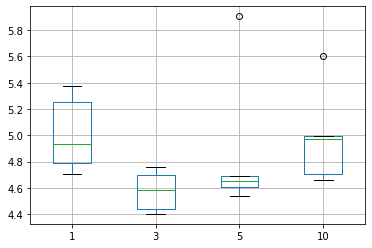

In [91]:
results.boxplot()

I have decided to choose epochs = 3

**Batch size**

Batch size controls how often to update the weights of the network.

Importantly in Keras, the batch size must be a factor of the size of the test and the training dataset.

In [103]:
def experiment(repeats, df, batch_size):
    
    dataset = df.values
    # Get the number of rows to train the model on
    training_data_len = int(np.ceil( len(dataset) * .95 ))
    
    scaler, scaled_data = scale_data(dataset)
    
    x_train, y_train, x_test, y_test = create_train_test_data(scaled_data)
    
    
    # run experiment
    error_scores = list()
    for r in range(repeats):
        batch_size = 1
        model = fit_lstm(x_train, y_train, batch_size, 3)
        # Get the models predicted price values 
        predictions = model.predict(x_test)
        predictions = scaler.inverse_transform(predictions)

        # Get the root mean squared error (RMSE)
        rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
        error_scores.append(rmse)
    return error_scores

In [104]:

repeats = 5
results_batch = DataFrame()
# vary training batches
batches = [1, 2, 4]
for b in batches:
    results_batch[str(b)] = experiment(repeats, series, b)

Epoch 1/3
680/680 [==============================] - 59s 86ms/sample - loss: 0.0078
Epoch 2/3
680/680 [==============================] - 49s 71ms/sample - loss: 0.0072
Epoch 3/3
680/680 [==============================] - 49s 71ms/sample - loss: 0.0074
Epoch 1/3
680/680 [==============================] - 57s 84ms/sample - loss: 0.0076
Epoch 2/3
680/680 [==============================] - 49s 72ms/sample - loss: 0.0077
Epoch 3/3
680/680 [==============================] - 49s 72ms/sample - loss: 0.0073
Epoch 1/3
680/680 [==============================] - 59s 87ms/sample - loss: 0.0078
Epoch 2/3
680/680 [==============================] - 51s 75ms/sample - loss: 0.0070
Epoch 3/3
680/680 [==============================] - 51s 76ms/sample - loss: 0.0067
Epoch 1/3
680/680 [==============================] - 60s 88ms/sample - loss: 0.0081
Epoch 2/3
680/680 [==============================] - 51s 75ms/sample - loss: 0.0072
Epoch 3/3
680/680 [==============================] - 51s 76ms/sample - loss:

In [105]:
results_batch.describe()

,1,2,4
count,5.000000,5.000000,5.000000
mean,4.998278,5.335812,4.851106
std,0.204293,0.146304,0.300251
min,4.730695,5.155149,4.632091
25%,4.866981,5.203229,4.643394
50%,5.057158,5.397913,4.657502
75%,5.076533,5.459392,5.020547
max,5.260025,5.463380,5.301993


<AxesSubplot:>

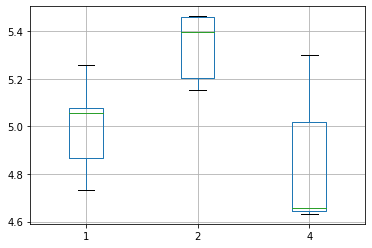

In [106]:
results_batch.boxplot()

Based on the above results, I have decided to go with batch size = 1.

### Final tuned model

In [108]:
dataset = bc_deaths.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))
    
scaler, scaled_data = scale_data(dataset)
    
x_train, y_train, x_test, y_test = create_train_test_data(scaled_data)

# hyper parameter values
batch_size = 1
epochs = 3

model = fit_lstm(x_train, y_train, batch_size, epochs)
        # Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

        # Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

Epoch 1/3
680/680 [==============================] - 161s 236ms/sample - loss: 0.0078
Epoch 2/3
680/680 [==============================] - 125s 184ms/sample - loss: 0.0074
Epoch 3/3
680/680 [==============================] - 121s 177ms/sample - loss: 0.0065


In [109]:
rmse

4.6515476381460035

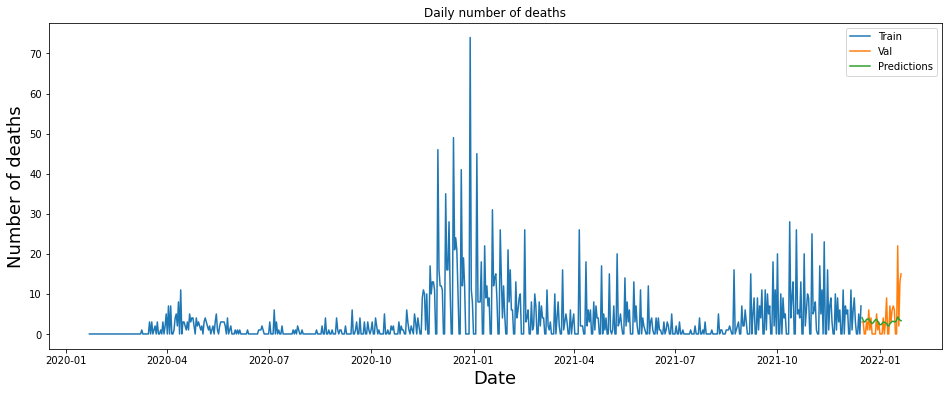

In [110]:
# Plot the data
train = bc_deaths[:training_data_len]
valid = bc_deaths[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,6))
plt.title('Daily number of deaths')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of deaths', fontsize=18)
plt.plot(train['daily_deaths'])
plt.plot(valid[['daily_deaths', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='best')
plt.show()

In [ ]:
# Additional references

In [94]:
training_data_len = int(np.ceil( len(series) * .95 ))
training_data_len

694

In [95]:
scaler, scaled_data = scale_data(dataset)

In [96]:
x_train, y_train, x_test, y_test = create_train_test_data(scaled_data)
len(x_train), len(x_test)

(680, 36)

In [98]:
730 - 694


36

In [102]:
num1 = 680
num2 = 36
def find_factors(num1, num2):
    factors=list()
    for i in range(2, min(num1, num2), 2):
        if num1% i == 0 and num2%i == 0:
            factors.append(i)
    return factors

find_factors(num1, num2)

[2, 4]